# Feature Extraction

Pure python code to extract features, in addition to MFCC 

In [1]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

from scipy.io import wavfile
import librosa

In [3]:
SAMPLING_RATE = 44100

In [4]:
X = np.load("data/raw_data.npy") 
y_binary = np.load("data/labels.npy")

In [5]:
X.shape

(1046, 220500)

## Diagnostic plots 
- Determine if normalization is necessary

In [6]:
y_idx = np.where(y_binary == 1)[0]

In [7]:
y_idx_songs = np.where(y_binary == 0)[0]

In [8]:
X_ads = X[y_idx, :]
X_songs = X[y_idx_songs, :]

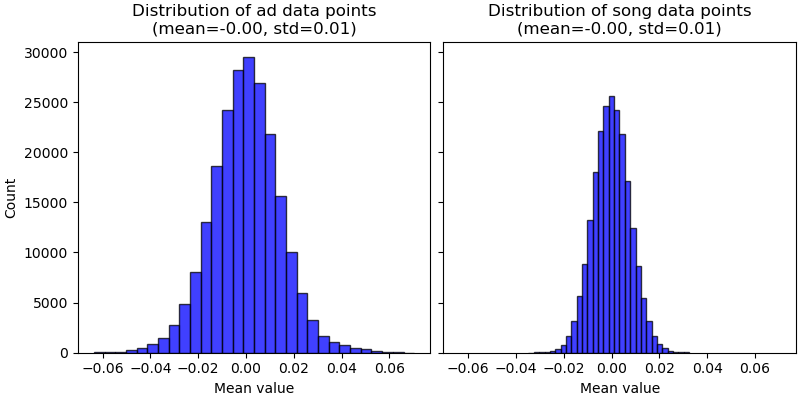

In [9]:
mean_ads = np.mean(X_ads, axis=0) 
mean_songs = np.mean(X_songs, axis=0) 

plt.close("all")

fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained", sharey=True, sharex=True)

ax = ax.flatten()

# plot ads data as binned distribution (histogram)
counts, bins, patches = ax[0].hist(mean_ads, bins=30, alpha=0.75, color='blue', edgecolor='black')
ax[0].set_title(f"Distribution of ad data points\n(mean={mean_ads.mean() :.2f}, std={mean_ads.std() :.2f})")
ax[0].set_xlabel("Mean value")
ax[0].set_ylabel("Count")


# plot songs data as binned distribution (histogram)
counts, bins, patches = ax[1].hist(mean_songs, bins=30, alpha=0.75, color='blue', edgecolor='black')
ax[1].set_title(f"Distribution of song data points\n(mean={mean_songs.mean() :.2f}, std={mean_songs.std() :.2f})")
ax[1].set_xlabel("Mean value")

plt.savefig("graphics/diagonistic-distribution.png", dpi=300)

plt.show()

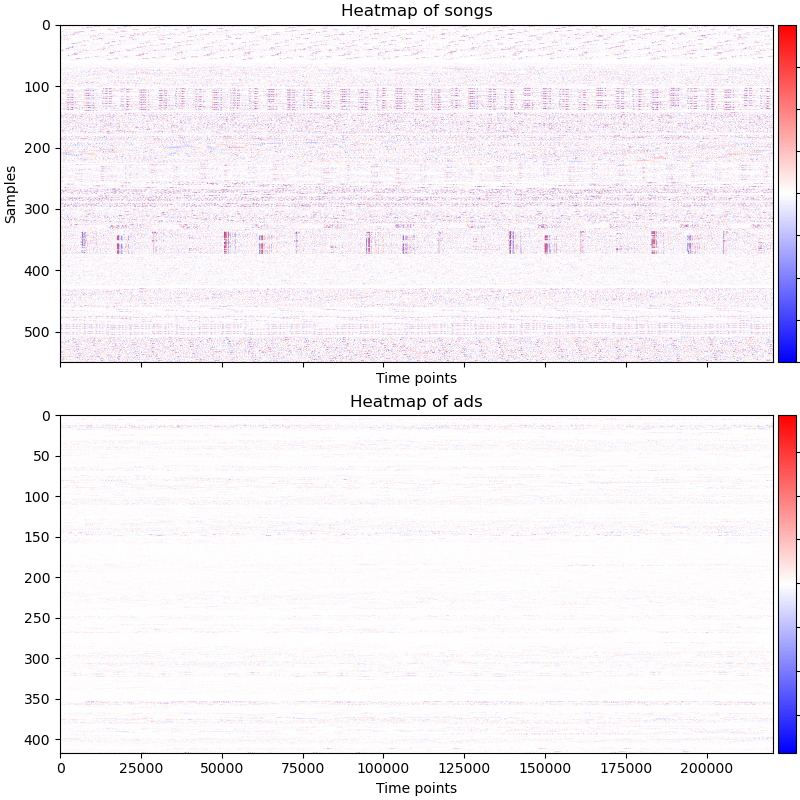

In [92]:
plt.close("all")

fig, ax = plt.subplots(2, 1, layout="constrained", figsize=(8, 8), sharex=True)

ax = ax.flatten()

im0 = ax[0].imshow(X_songs, aspect="auto", cmap="bwr")
ax[0].set_title("Heatmap of songs")
ax[0].set_xlabel("Time points")
ax[0].set_ylabel("Samples")

# set up colobar
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2.5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')


im1 = ax[1].imshow(X_ads, aspect="auto", cmap="bwr")
ax[1].set_title("Heatmap of ads")
ax[1].set_xlabel("Time points")
ax[0].set_ylabel("Samples")

# set up colobar
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2.5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.savefig("graphics/diagonistic-heatmap.png", dpi=300)

plt.show()

In [87]:
X_ads.max()

0.95910645

In [88]:
X_songs.max()

0.9999695

## For a single case

### Pitch

In [16]:
i = 0
pitch, magnitude = librosa.piptrack(y=X[i, :], sr=SAMPLING_RATE)

In [17]:
pitch.shape

(1025, 431)

In [18]:
magnitude.shape

(1025, 431)

In [28]:
pitch.reshape(-1).shape # what happens if we vectorize the pitch

(441775,)

In [27]:
magnitude.shape

(1025, 431)

**DECISION: lets use Crepe**
- Predicts the pitch for every time point
- As opposed to librosa, which gives a vector (as a column) of possible frequencies at each time point (usually take the max, but I'm not confident in this)

In [34]:
# !pip install crepe # do this once

In [39]:
# !python3 -m pip install tensorflow # do this once

In [54]:
# !python -m pip install scipy==1.11 # do this once
# need to downgrade for no error using librosa's tempo function

In [6]:
import crepe

In [7]:
i = 0
time, frequency, confidence, activation = crepe.predict(X[i, :], SAMPLING_RATE, viterbi=False)

2024-04-22 00:07:13.941809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step


In [26]:
frequency.shape

(500,)

### Tempo

In [9]:
i = 0
tempo, beats = librosa.beat.beat_track(y=X[i, :], sr=SAMPLING_RATE)

In [10]:
tempo

129.19921875

### MFCC

In [114]:
i = 0
mfcc = librosa.feature.mfcc(y=X[i, :], sr=SAMPLING_RATE, n_mfcc=14)
mfcc = mfcc[1:, :] # remove the first coefficient

In [71]:
# `temp` is retrieved from MATLAB raw MFCC values (no prrocessing, simply the output)
matlab_mfcc_sample1 = pd.read_csv("temp.csv", header=None)

In [76]:
X_mfcc_1 = matlab_mfcc_sample1.to_numpy()

In [72]:
# this is the processed MFCC table that Christian generated
matlab_mfcc = pd.read_csv("data/mfcc_data.csv")

In [73]:
X_mfcc = matlab_mfcc.loc[:, matlab_mfcc.columns[3:]].to_numpy()

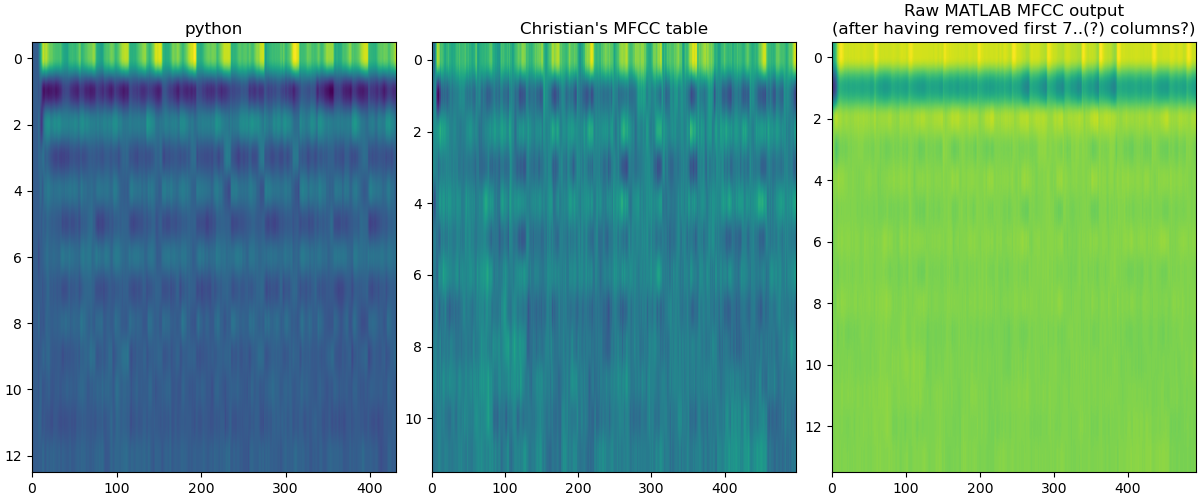

In [118]:
plt.close("all")

fig, ax = plt.subplots(1, 3, figsize=(12, 5), layout="constrained")

ax = ax.flatten()

im0 = ax[0].imshow(mfcc, aspect="auto")
ax[0].set_title("python")

im1 = ax[1].imshow(X_mfcc[i, :].reshape(12, -1), aspect="auto")
ax[1].set_title("Christian's MFCC table")

im2 = ax[2].imshow(X_mfcc_1[6:, :].T, aspect="auto")
ax[2].set_title("Raw MATLAB MFCC output\n(after having removed first 7..(?) columns?)")

plt.show()

### Delta Delta Coefficient

In [108]:
i = 0
mfcc = librosa.feature.mfcc(y=X[i, :], sr=SAMPLING_RATE)
mfcc = mfcc[1:, :] # remove the first coefficient
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

## Make everything

In [124]:
import tqdm
from tqdm import tqdm

In [126]:
pitch_values = []
tempo_values = []
mfcc_values = []
delta_values = []
delta2_values = []

for i in tqdm(range(X.shape[0])):
    # PITCH
    # Crepe
    _, frequency, _, _ = crepe.predict(X[i, :], SAMPLING_RATE, viterbi=False, verbose=0)

    # Librosa
    # pitch, _ = librosa.piptrack(y=X[i, :], sr=SAMPLING_RATE)

    # TEMPO
    tempo, _ = librosa.beat.beat_track(y=X[i, :], sr=SAMPLING_RATE)

    # MFCC
    mfcc = librosa.feature.mfcc(y=X[i, :], sr=SAMPLING_RATE)
    mfcc = mfcc[1:, :] # remove the first coefficient

    # DELTA
    mfcc_delta = librosa.feature.delta(mfcc)

    # DELTA-DELTA
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # pitches.append(pitch.reshape(-1))
    pitch_values.append(frequency)
    tempo_values.append(tempo)
    mfcc_values.append(mfcc.reshape(-1))
    delta_values.append(mfcc_delta.reshape(-1))
    delta2_values.append(mfcc_delta2.reshape(-1))

100%|███████████████████████████████████████| 967/967 [1:02:52<00:00,  3.90s/it]


In [144]:
pitch_values = np.array(pitch_values)

In [148]:
tempo_values = np.array(tempo_values)

In [149]:
mfcc_values = np.array(mfcc_values)

In [150]:
delta_values = np.array(delta_values)

In [151]:
delta2_values = np.array(delta2_values)

In [167]:
tempo_values = tempo_values.reshape(X.shape[0], 1)

In [ ]:
["pitch", "tempo", "mfcc", "delta", "delta-delta"]

In [170]:
X_features = np.concatenate([pitch_values, tempo_values, mfcc_values, delta_values, delta2_values], axis=1)

In [171]:
X_features.shape

(967, 25068)

In [172]:
np.save("data/processed_data.npy", X_features)